In [13]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

In [34]:
class OxfordPetsDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform if mask_transform is not None else transform

        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.images)
    
    def preprocess_mask(self, mask):
        mask = mask.astype(np.float32)
        mask[mask == 2.0] = 0.0 # Background 
        mask[(mask == 1.0)] = 0.5 # Item
        mask[(mask == 3.0)] = 1.0 # Edge
        return mask

    # It defines how an item from the dataset is fetched given its index
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        trimap = np.array(Image.open(mask_path))
        mask = self.preprocess_mask(trimap)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = OxfordPetsDataset(images_dir='images', masks_dir='annotations/trimaps', transform=transform, mask_transform=mask_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


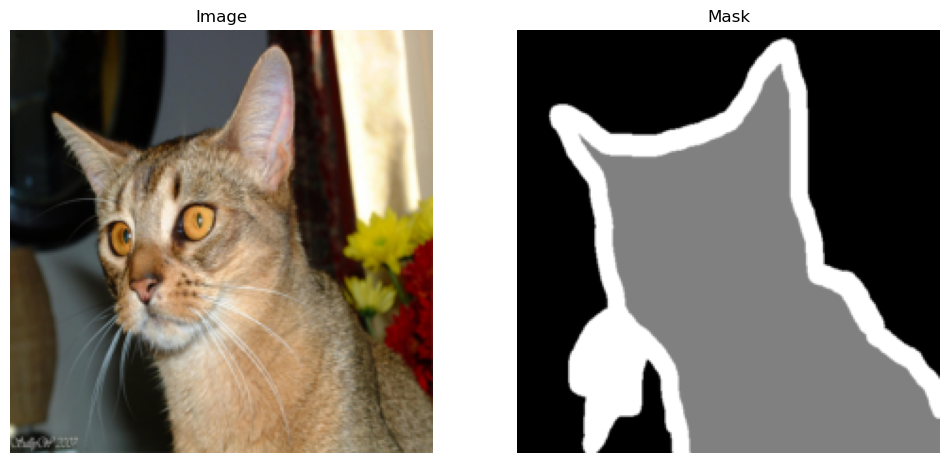

In [38]:
# Inspect dataset
image, mask = dataset[10]

# Rearrange the dimensions
# from (channels, height, width) to (height, width, channels)
image_np = image.numpy().transpose(1, 2, 0)

# Normalize the image array to [0, 1] for visualization
# This reverses the normalization applied during the transform
image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  
image_np = np.clip(image_np, 0, 1)  # clip to the range [0, 1] for valid image values

# Convert the mask tensor to a numpy array for visualization
# Since the mask is a single-channel image, we use squeeze to remove the channel dimension for plotting
mask_np = mask.numpy().squeeze()

# Visualize the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Image')
plt.axis('off')

# Visualize the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()


In [39]:
class FeatureToSegmentation(nn.Module):
    # h size is [batch_size, 2048]
    def __init__(self, feature_dim=2048, num_classes=2):  # Adjusted for binary segmentation
        super(FeatureToSegmentation, self).__init__()
        self.fc1 = nn.Linear(feature_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes * 224 * 224)  # Output reshaped for segmentation
        self.num_classes = num_classes

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        # Reshape to [N, C, H, W] for segmentation
        x = x.view(-1, self.num_classes, 224, 224)
        return x


In [ ]:
# Assume `simclr_model` is your SimCLR model instance prepared for feature extraction
segmentation_model = FeatureToSegmentation(feature_dim=2048, num_classes=2)
optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 20
for epoch in range(num_epochs):
    for images, masks in dataloader:  # Ensure masks are correctly formatted for binary segmentation
        optimizer.zero_grad()

        # Extract features with SimCLR
        with torch.no_grad():
            # simCLR output h
            features, _ = simclr_model.model(images)

        # Predict segmentation maps
        segmentation_maps = segmentation_model(features)
        
        # Compute and backpropagate loss
        loss = criterion(segmentation_maps, masks)
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch}, Loss: {loss.item()}")